In [24]:
# Luminosity, Schechter function, etc. 

# Runtime error:

# Need to calculate E(z) only once, and re-use that vector for each calculation of Distance Modulus, rather than
# having the integrals nested.

# should also check for divide by zero, or numbers going above max double float size (-1.797e+308, 1.797e+308)
# 

# Imports
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [130]:
# David Hogg Paper
EDS = np.array([1, 0, 0])
LD = np.array([0.05, 0, 0.95])
HL = np.array([0.2, 0.8, 0])

#Msci paper
# Omega M, Omega Lambda, Omega K
LCDM = np.array([0.3, 0.7, 0])
EDS = np.array([1, 0, 0])
OCDM = ([0.3, 0, 0.7])

# W0, W1
wBasic = np.array([-1, 0])
w8 = np.array([-0.8, 0])
w9 = np.array([-0.9, 0])
w11 = np.array([-1.1, 0])
w12 = np.array([-1.2, 0])

# Schecher parameters
# Phi1, Phi2, a1, a2, Mass*
# The Schechter parameters found  in the paper by Baldry, Driver, Loveday, Taylor et al. (2011)
CanonicalSchechter = np.array([3.96*10**-3, 0.79*10**-3,-0.35, -1.47, 10**10.66])

zArray = np.linspace(0.01, 5, num = 200)
MagArray = np.linspace(-30, 50, num = 200)

In [131]:
# Constants

c = 3 * 10**8
H_0 = 70
D_H = (c / H_0)
MSol = 1.99 * 10**30

In [132]:
def Ez(z, OmeM, OmeCos, OmeK, w0, w1): #Doesn't switch equation automatically
    if OmeK > 0: # Is this distribution of equations true?
        return np.sqrt(OmeM * (1 + z)**3 + OmeK * (1 + z)**2 + OmeCos)
    elif OmeK == 0:
        return np.sqrt(OmeM * (1 + z)**3 + (1 - OmeM) * (1 + z)**(3 * (1 + w0 + w1)) * np.exp(-3 * w1 * z))

In [133]:
# Comoving distance for line-of-sight distance calculation

def ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1):
    integral = integrate.quad(lambda Z: 1/(Ez(Z, OmeM, OmeCos, OmeK, w0, w1)), 0, z) # integration holds error
    return integral[0]

ComDisLOSVec = np.vectorize(ComDisLOS, excluded=['ws'])

In [134]:
def ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1):
    if OmeCos == 0:
        A = 2 - OmeM * (1-z)
        B = (2 - OmeM) * np.sqrt(1 + OmeM * z)
        C = OmeM**2 * (1 + z)
        distance = 2 * (A - B)/C
        return distance
        
    else:
        if OmeK > 0:
            distance = (1 / np.sqrt(OmeK)) * np.sinh(np.sqrt(OmeK) * ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1) )
        elif OmeK < 0:
            distance = (1 / np.sqrt(np.absolute(OmeK))) * np.sin(np.sqrt(np.absolute(OmeK)) * ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1) )
        elif OmeK == 0:
            distance = ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1)
    return distance

ComDisTraVec = np.vectorize(ComDisTra, excluded=['ws'])

In [135]:
# Luminosity distance

def LumDist(z, OmeM, OmeCos, OmeK, w0, w1):
    return (1 + z) * ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1)

In [136]:
# Distance Modulus

def DistanceModulus(z, OmeM, OmeCos, OmeK, w0, w1):
    return 5 * np.log10(LumDist(z, OmeM, OmeCos, OmeK, w0, w1)*(D_H * 10**(-10)))
                        
DistModVec = np.vectorize(DistanceModulus)

In [137]:
# magnitudes = np.linspace(5, 15, num = 200)

# def SchechterDiff(Phi, a, Mstar, M):
#     return Phi * np.log(10) * (10**(0.4*(Mstar - M)))**(a + 1) * np.exp(-10**(0.4*(Mstar-M)))

# #np.vectorize(SchechterDiff)

# def Schechter(Phi, a, Mstar, M):
#     integral = integrate.quad(lambda m: (SchechterDiff(Phi, a, Mstar, m)), 0, np.inf) # integration holds error
#     return integral[0]

# values = SchechterDiff(1.2 * 10**(-2), -0.25, 7, magnitudes)

# plt.plot(magnitudes, values)
# plt.show()

# SchechterVec = np.vectorize(Schechter)

In [138]:
# Schechter function for masses
# Double schechter function from paper by Baldry, Driver, Loveday, Taylor et al. (2011)

def DoubleSchechterDiff(Phi1, Phi2, a1, a2, MassStar, Mass): #in MASSES =(
    Density = np.exp(-Mass/MassStar) * (Phi1 * (Mass/MassStar)**a1 + Phi2 * (Mass/MassStar)**a2 ) * (1/MassStar)
    return Density


DoubleSchechterDiffVec = np.vectorize(DoubleSchechterDiff)

In [139]:
# Luminosity from mass
# Currently just a stand-in function!!! Not even an approximation!!!!!!!!
# But this is what Dr. Conselice said to do in the supervision meeting; "just use luminosity *3 or something"

def LumfromMass(mass):
    Lum = 3 * mass * Msol # units of solar mass
    return Lum
# Mass from luminosity
def MassFromLum(Lum):
    mass = Lum/(3 * MSol)
    return mass

In [140]:
# Absolute Magnitue from Luminosity
def MagnitudeFromLum(Lum):
    Mag = -2.5*np.log10(Lum/3.0128*10**28)
    return Mag
# Luminosity from absolute magnitude
def LumFromMagnitude(Mag):
    Lum = 10**(-Mag/2.5) * 3.0128*10**28
    return Lum

In [141]:
# magnitude from Absolute Magnitude
# m = M + DM + K
def MagFromAbsMag(Mag, DM, K):
    mag = Mag + DM + K
    return mag

def AbsMagFromMag(mag, DM, K):
    Mag = mag - DM - K
    return Mag


In [142]:
# Schechter function as a distribution of magnitudes 
# 
def SchechterMagnitudes(Phi1, Phi2, a1, a2, MassStar, mag, DM, K):
    Density = DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude(AbsMagFromMag(mag, DM, K))))
    return Density

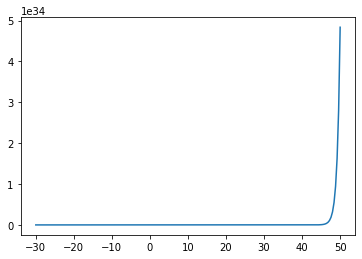

In [143]:

MagnitudesDistrib = SchechterMagnitudes(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], MagArray, 0, 0)

plt.plot(MagArray, MagnitudesDistrib)
plt.show()


Now I wanted to check what was going on each step of the way, so I test the behaviour of a set of magnitudes as they go through each function.

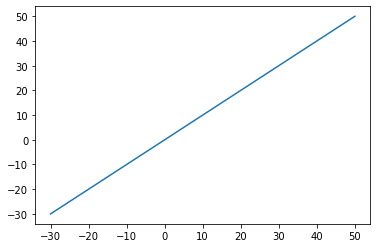

In [144]:

AbsoluteMagnitudes = AbsMagFromMag(MagArray, 0, 0)

plt.plot(MagArray, AbsoluteMagnitudes)
plt.show()

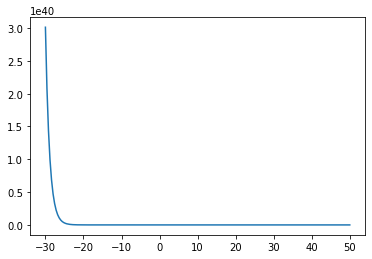

In [145]:
Luminosities = LumFromMagnitude(AbsoluteMagnitudes)

plt.plot(MagArray, Luminosities)
plt.show()

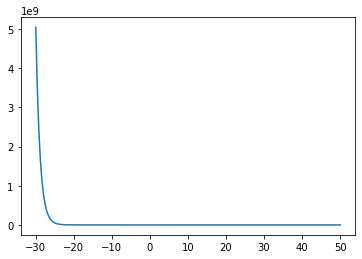

In [146]:
Masses = MassFromLum(Luminosities)
plt.plot(MagArray, Masses)
plt.show()

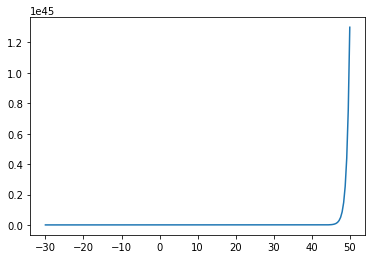

In [161]:
# Schechter distribution of magnitudes

Density = DoubleSchechterDiffVec(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], \
                                 CanonicalSchechter[3], CanonicalSchechter[4], MassFromLum(LumFromMagnitude(
    AbsMagFromMag(MagArray, DistanceModulus(0.5, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1]), 0))))

plt.plot(MagArray, Density)
plt.show()


In [159]:
def DensityAtZ(Phi1, Phi2, a1, a2, MassStar, z, OmeM, OmeCos, OmeK, w0, w1):
    integral = integrate.quad(lambda M: DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude
                        (AbsMagFromMag(M, DistanceModulus(z, OmeM, OmeCos, OmeK, w0, w1), 0)))), -np.inf, 25)
    return integral[0]

In [160]:
print(DensityAtZ(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], 
 0.5, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1]))

# One value of density at a disance z = 0.5 gives a runtime error. Must resolve this as need to calculate full spectrum
# of different z values.

# Also; 1.9 * 10^30 seems unnecessarily big? But this may also be because of the units of different quantities going
# into functions; as the luminosity to mass function is very much just a dummy function at the moment, haven't
# concentrated too much on units, concentrated on behaviour instead.


1.9158846073244036e+30


C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
